# Loss landscape exploration in MNIST Digits

## Motivation
In class we discussed a number of optimizers from a qualitative perspective. Because deep learning is a non-convex optimization, it's extremely difficult or impossible to get the same mathematical guarantees as if we were discussing convex optimization. Instead, we turn to somewhat "intuitive" or qualitative ideas. For instance, one of these ideas is to allow the update direction to be based on the gradient, but also based on the gradients from previous iterations, or the "momentum". We mentioned a [paper](https://arxiv.org/abs/1706.08500) where Adam is shown to behave as a Heavy Ball with Friction (HBF), which would allow it to skip over local minima that Stochastic Gradient Descent (SGD) would get caught in.

While there are mathematical equations to derive an Ordinary Differential Equation (ODE) governing the evolution of the parameters, the resulting ODE may not have an intuitive physical meaning, or the derivation may only hold for certain optimizer parameter values. For instance, in the [derivation of Adam as a HBF](https://arxiv.org/abs/1706.08500), the optimzer parameter $\beta_1$ and $\beta_2$ must be chosen as specific values (for reference, these paramter control the averaging of the gradient and of the square of the gradient). Thus, while we can sometimes have a physical understanding of what an optimizer does, this is generally not the case.

Therefore, we turn to another method to examine the behavior of optimizers on a high-dimensional, non-convex loss function. One method is to visualize a loss function, and optimizers in two dimensions, via some method of dimensionality reduction of the original high-dimensional parameters. We focus more on a theoretical explanation of this idea, and briefly show one implementation. We also discuss, but do not succeed in implementing, a change that could make this visualization more informative.

Additionally, based on lectures in class, we will choose a problem of image classification as an example. We will create and explain all the dimensions in a Convolutional Neural Network (CNN). Out of curiousity, we will also look at some of the intermediate output channels of this CNN. Choosing this example grounds this notebook in the recent class material, while still allowing for computations to be done in a reasonable amount of time. By comparison, the higher dimensionality and larger dataset used for AlexNet would make this exploration much more computationally expensive, to the point where it would detract from the underlying goal and learning.

## Loading Data
PyTorch already includes many popular [datasets](https://pytorch.org/vision/stable/datasets.html) that just need to be locally downloaded. The way PyTorch includes this data makes loading easier, sometimes with the data having a designated test set that is loaded differently. Here, we'll load the training set, which we will use to make our validation set. Loading with the `transform` argument will apply the corresponding function to the inputs. We could also normalize here, but in this case it's not really a problem. Similarly, loading with the `target_transform` defined will apply that function to the outputs. For categorical data, it is good practice to use _one-hot encoding_, where the label is converted from $\{1,2,...,n_{categories}\}$ to $\{ 0,1 \}^{n_{categories}}$, where there are $n_{categories} - 1$ elements of the new vector with value `0`, and one element of the new vector with value `1`. The index of where this `1` occurs gives the original category number of the label. We'll use one-hot encoding later, not while loading the data.

Throughout my code, I use some outside resources, but just to implement the ideas I'm thinking about. For instance, in this next section, I look at https://pytorch.org/tutorials/beginner/basics/data_tutorial.html, but really try to stay away from retyping the example code.

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


Text(0.5, 1.0, 'Label = 5')

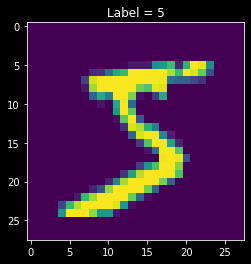

In [1]:
from random import shuffle
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

mnist_data = torchvision.datasets.MNIST(root='./',download=True,train=True, transform=ToTensor())
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=32, shuffle=False)
print(data_loader.dataset)
print(data_loader)

# Grab a batch from the data loader
imgs, labels = next(iter(data_loader))

# Grab the first sample and label from the batch.
img = imgs[0]
label = labels[0]

# plt.imshow(img[0,:,:]) # This was my temporary solution, and for a 1x28x28, this does the same as squeezing
plt.figure()
plt.imshow(img.squeeze())
plt.title(f'Label = {label}')

## Designing the Model
We'll use a Convolutional Neural Network to map from the input image space $\mathbb{R} ^{784}$ ($28 \times 28$) to the output space $\mathbb{R} ^{10}$ (10 categories of labels). For later convenience, call this mapping $f_\theta : \mathbb{R} ^{784} \to \mathbb{R} ^{10}$, where $\theta$ are the parameters of the neural network. In reality, the samples have discrete pixel values between $0$ and $255$, and we will want a one-hot type output, with all zeros but a single one. However, we can still apply the function to instances that make no sense, such as an "image" that has pixel values larger than 255.

We'll use [PyTorch's convolution function](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) `Conv2d`, which takes inputs `in_channels`, `out_channels`, `kernel_size` and through pooling outputs some metric (such as the maximum or average) over the kernel for each output channel. This [visualization](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) and this [explanation](https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148#:~:text=Each%20output%20channel%20is%20the,*3%3D12%20convolution%20kernels.) go through the convolution process more thoroughly than we will here.

To design the CNN, I iteratively went through layers and checked the output sizes. When I got stuck with errors, I would comment out future steps / layers and check what went wrong. I learned a few things, by trial by error. First, we're usually dealing with a 4 dimensional tensor of the following form

$$x \in \mathbb{R}^{\text{batch size} \times \text{channels} \times \text{length} \times \text{height}}$$

* batch size (usually 16, maybe 32... whatever I loaded in above.), the number of samples that we are loading, based on our `data_loader`
* channels = 1, 8, 16, the number of "color" channels. We begin with 1 color channel (grayscale), then through the convolution process, we create parameters so that we can upsample to 8 "color" channels in our first `Conv2d`, and then upsample again to 16 in our second `Conv2d`.
* length, width = 28, then varies. This was the hardest to keep track of and warrants its own discussion.

### Length and Width in CNN
For simplicity, note that length=width for the functions used here. These dimensions are the size of our image, but they change through both `Conv2D` and `AvgPool2d` (or any pooling). Because the convolutions use kernels with sizes greater than 1, when we encounter edges within our kernel, we would have to stop before we run a part of the kernel over the edge. However, by adding padding, we can just assume some value for pixels that are over the edges. With zero padding (as is default for `Conv2d`), we assume the pixel values are `0` over the edge. This means that `Conv2D` won't change the length or width. However, for pooling, both the arguments impact the length/width differently. The first argument is the `kernel_size`, which has the same problem as mentioned for `Conv2D`: we won't be able to map to the same length/width because the kernel would need information beyond the edge. The length/width are decreased by `kernel_size-1` (where we subtract `1` because a kernel of `1` returns the same image size). Then, the second input to pooling is the `stride`. This is how many pixels to skip over (in each dimension) while moving our kernel across the input image. If we choose `stride=1`, we just move to the next pixel, and this parameter does not reduce the size any. In general, this parameter divides the number of input pixels to give the output pixels (in each dimension), and we will round up. For instance, an image with 5 pixels in length (and width) and `stride=2` would give one kernel starting at the $(1,1)$, the next starting at $(1,3)$, and the last at $(1,5)$ (and then start again on $(3,1)$). Thus, we would have a resulting image with 3 pixels in each direction. Thus, the expression for the resulting length/width is `ceil(length - (kernel_size-1) / stride)`

Once we are down with the convolution and pooling steps, we rescale the images into a vector, where the size of each vector of the batch is given by the length times width times number of channels. After this, we use a regular dense Multilayer Perceptron (MLP) to reduce this dimension to our expected 10 output classes.

Later, we will see that the size of the model (the number of parameters) is important for what we want to do. I started with a model with $3245$ parameters, and needed to scale that down to a smaller model for runtime and memory purposes.

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation_fcn = nn.ReLU
        self.convolution_part = nn.Sequential(
            # 28 for both width and height, with 1 channel
            nn.Conv2d(in_channels=1,out_channels=3,kernel_size=5),
            self.activation_fcn(),
            # 28-(5-1) = 24 for both width and height, with 8 channels
            nn.AvgPool2d(4,2),
            # ceil((24-4+1) / 2) = ceil(21/2) = ceil(10.5) = 11
            nn.Conv2d(3,5,4),
            # 11-(4-1) = 8 for width and height, 16 channels now.
            self.activation_fcn(),
            # Still 8
            nn.AvgPool2d(2,2)
            # ceil((8-(2-1))/2) = ceil(7/2) = 4
        )

        self.mlp_part = nn.Sequential(
            # 4 by 4 reshaped into a 16 by 1 vector representing the image for one channel. Then 16 pixels by 5 channels = 80
            nn.Linear(80, 32),
            # Regular linear layer, output 32 units
            self.activation_fcn(),
            nn.Linear(32,10)
            # Final output of 10 units. This is our representation of the 10 categories.
        )


    def forward(self, x):
        # Apply the convolution part, then flatten and apply the MLP part.
        conv_out = self.convolution_part(x)
        mlp_out = self.mlp_part(torch.flatten(conv_out,1))
        return mlp_out

cnn_model = CNN()

# Just for debugging the creation of the CNN:
for i, data in enumerate(data_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    print(inputs.shape)
    outputs = cnn_model(inputs)
    print(outputs.shape) 
    # print(labels.shape) 
    # print(nn.functional.one_hot(labels).shape) 
    break

torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


### Connection to Class

In class, we discussed AlexNet, and specifically went through some of the layers. AlexNet is big, even 10 years later, so I don't load it on my computer. Instead, I try and design and understand the sizes of my own CNN. This is just like in class when we went through some of the layers of AlexNet and discussed the sizes of the convolution and pooling layers. Also, a key feature of AlexNet was using GPUs, and in this project I'm not looking at using my GPUs.

## Training the Model

Our end goal is to look at the loss landscape and compare optimizers. Usually, we would care about an accuracy metric, but this project will already be introducing a lot of new ideas. Some of the formatting is from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. To find a suitable learning rate, I started with a small learning rate $10^{-4}$, and very few epochs. I ran the training and showed the losses. If the loses were decaying over all the epochs and never blowing up, then I increased the learning rate. The losses blew up at a learning rate of $1.0$, so I stay below this level. Overall, this took many iterations of "manual hyperparameter tuning" to reach a reasonable learning rate. Then, I slowly increased the number of epochs to make sure that the training wouldn't diverge when I went for a huge run.

In [33]:
# Restart with a clean model
model = CNN()

epochs = 500
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(),lr=lr)
loss_fcn = nn.CrossEntropyLoss()
losses = []

# Iterate through epochs
for epoch in range(epochs+1):
    loss_of_epoch = 0.0

    # This will let us compute the loss on the final epoch, and not change the parameters
    # We don't usually need this. It's just nice for what we want to do later.
    perform_opt_step = epoch<epochs

    # Iterate through batches
    for i, data in enumerate(data_loader):
        inputs, labels = data

        if(perform_opt_step): 
            # Zero the .grad property of all the optimizer's optimization parameters
            optimizer.zero_grad()

            # Compute the loss
            outputs = model(inputs)
            loss = loss_fcn(outputs,labels)

            # Update the .grad property of all tensors that have requires_grad=True
            loss.backward()

            # Use the .grad property of the optimizer's optimization parameters to update them.
            optimizer.step()
        else:
            with torch.no_grad():
                # Compute the loss
                outputs = model(inputs)
                loss = loss_fcn(outputs,labels)

        loss_of_epoch+=loss.item()

    # Keep track of our training history
    losses.append(loss_of_epoch)


The runtime of the above code is quite large. For instance, running with 500 epochs (and a learning rate of $0.001$) took over 2 hours on my machine, although for a larger model while I was still figuring out this notebook. I'm not using any GPUs, although that would probably speed up the process... It would also add a lot of more complexity to what will already be a pretty substantial jump. I may undertake this as a separate notebook.

34.40937618109428


Text(0.5, 0, 'Epochs')

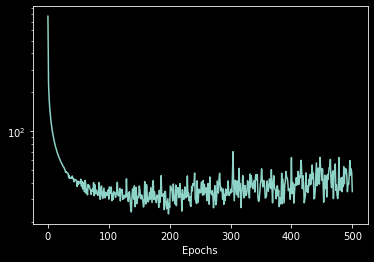

In [34]:
print(losses[-1])

plt.figure()
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epochs')

## Save the model
Let's save the model so if the notebook closes I don't need to rerun the training and waste more electricity. We actually just save the model parameters (with a key), and if we have an instance of the `CNN` class, we can load these parameters in the correct place (using the key). There's more information on this [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html), specifically using PyTorch's `state_dict`.

In [35]:
model_fname = 'trained_smaller_model.pt'
torch.save(model.state_dict(), model_fname)
# To load: create a new model, then load the state dictionary to match parameters with keys
# model = CNN()
# model.load_state_dict(torch.load(model_fname))

## Check Accuracy
Let's check the accuracy of the model over the training set. We care about accuracy on the testing set much more, but we're going to leave that dataset alone until we've determined all the hyperparameters. I want to use the training accuracy to see if I can get away with a shorter training time (fewer epochs).

In [3]:
from statistics import mean

def accuracy(model, data_loader):
    # Set to evaluation mode
    model.eval()

    batch_accuracies = []
    for i, data in enumerate(data_loader):
        inputs, labels = data

        outputs = model(inputs)
        output_labels = torch.argmax(outputs, dim=1)
        acc = sum(output_labels==labels)/data_loader.batch_size
        batch_accuracies.append(acc.item())

    # Because the batches are all the same size, we can just average over all the batches:
    return mean(batch_accuracies)

accuracy(model, data_loader)

NameError: name 'model' is not defined

So I trained my model for 10 epochs and the training accuracy is already 98%? This can't be right. Let's see how an untrained model does. Good thing we write modular code so we can just reuse the accuracy function for this and other cases.

In [37]:
untrained_model = CNN()
accuracy(untrained_model, data_loader)

0.09751666666666667

Sanity check complete. The untrained model gets around 10% accuracy, which is what we expect by random chance. So, the CNN is just extremely powerful for image data, and even after 10 training epochs we're extremely accurate (at least on the training data). Let's call training complete. It's possible I'll rerun the training with more epochs when my machine isn't busy running anything else.

Note that in the above, we don't use a validation set, so it's hard / impossible to tell if we are overfitting. The purpose of this notebook isn't to necessarily train a CNN well, so it's okay if we overfit and don't know about. If we did, we might see something interesting in the loss landscape later.

## Visualize the loss function

PyTorch stores parameters in weird ways. In math, we're used to the parameters as a vector, that is $\theta \in \mathbb{R}^n$, but PyTorch stores them as an iterable corresponding to the different features that each sets of the parameters are used in for the forward model. We'll convert to the vector framework as it's easier to work with and to apply mathematical theory to.

In my first assignment, I looked at a least squares linear regression problem, and I also showed loss surfaces. However, for that problem, $\theta \in \mathbb{R}^2$, which is drastically different than this case.

In [7]:
theta_opt = nn.utils.parameters_to_vector(model.parameters())
print(theta_opt.shape)

torch.Size([3245])


We see that $\theta \in \mathbb{R}^{3245}$ (and with my previous, larger model, $\theta \in \mathbb{R}^{30378}$). We want to visualize the loss landscape, meaning we want to look at $L(\theta)$ (where $L$ is the loss function). How can we visualize a function that has so many inputs?

### Coordinate Transformation

There are a few ways we can try. We can choose two directions, $\theta_a , \theta_b \in \mathbb{R}^{3245}$, and then look at a graph of how $L$ depends on these two directions. But now, how do we choose $\theta_a$ and $\theta_b$?

In the simple approach, we can choose them randomly. In the difficult approach, we can choose them based off of which directions we think will be the most important. We'll start with the first, simple method, and we'll further clarify the second method when we get to it.

We can measure how similar $\theta$ is to $\theta_a$ or $\theta_b$ by using an inner product (which is the dot product for our case). We'll use the coordinates $(\eta_a, \eta_b)$ to measure how much $\theta$ is in directions $\theta_a$ and $\theta_b$ (respectively). We'll also divide by a normalizing factor to make things nicer. That is,
$$
\begin{align*}
    \eta_a & = \frac{\langle \theta , \theta_a \rangle}{\langle \theta_a , \theta_a \rangle} \\
    \eta_b & = \langle \theta , \theta_b \rangle
    % \label{eq:coords}
\end{align*}
$$

If this is confusing, check the example of $v=[3,1,4]^T$ by using $v_a = [1, 0, 0]^T$ and $v_b = [0,1,0]^T$ (and get $\eta_a = 3$, $\eta_b = 1$ as the corresponding coordinates). Overall this is the same idea as [basis vectors](https://en.wikipedia.org/wiki/Basis_(linear_algebra)), but we stop at two vectors, rather than 3245 vectors, so we don't have a basis.

We will also recenter the coordinate system, so that `theta_opt`, our model's final parameters is at $(0,0)$. This is just for convenience. Here's the function that will do all this math.

In [8]:
def get_coords(theta, theta_opt, theta_a, theta_b):
    theta_centered = theta - theta_opt
    eta_a = torch.dot(theta_centered,theta_a) / torch.dot(theta_a,theta_a)
    eta_b = torch.dot(theta_centered,theta_b) / torch.dot(theta_b,theta_b)

    coords = [eta_a, eta_b]
    return coords

Now, we want to visualize $L(\theta)$ for $\theta \in \text{span} \{ \theta_a, \theta_b \}$. We'll choose a subset of this to actually show. We do this by choosing $(\eta_a, \eta_b)$ and then computing the corresponding $\theta$ by

$$
    \theta = \eta_a \theta_a + \eta_b \theta_b
$$

We'll make another function for this. There's a little extra math to account for the centering that already happened. This code is not general to higher dimensions of coordinates, but our purpose is to use 2 dimensions to visualize what's going on, so that is fine.

In [9]:
def get_theta(coords, theta_opt, theta_a, theta_b):
    theta = theta_opt + coords[0]*(theta_a) + coords[1]*(theta_b)
    return theta

Now, verify the previous two functions. We won't stress what _kind_ of "random" we choose. Here's what we check. The coordinates of `theta_opt` should be $(0,0)$ and vice versa. The coordinates of $\theta_a$ and $\theta_b$ should be $(1,0)$ and $(0,1)$ respectively.

In [10]:
theta_a = torch.randn_like(theta_opt)
theta_b = torch.randn_like(theta_opt)

# We're dealing with model parameters, and we won't use backward for anything.
with torch.no_grad():
    coords_center = get_coords(theta_opt, theta_opt, theta_a, theta_b)
    coords_a = get_coords(theta_a, theta_opt, theta_a, theta_b)
    coords_b = get_coords(theta_b, theta_opt, theta_a, theta_b)
    corresponding_theta = get_theta(coords_center, theta_opt, theta_a, theta_b)

    print(coords_center)
    print(coords_a)
    print(coords_b)
    print(torch.norm(corresponding_theta-theta_opt))

[tensor(0.), tensor(0.)]
[tensor(1.0039), tensor(0.0222)]
[tensor(0.0092), tensor(1.0168)]
tensor(0.)


### Visualization Functions
Using the random directions from before, let's visualize the loss landscape. Remember, our ultimate goal is to get a physical intuition for some of the optimization methods we discussed. This function is modified from my first project.

In [42]:
def make_loss_visualization(n_grid,expansion_factor,l):
    
    eta_a_bnds = torch.linspace(-1,1,n_grid)*expansion_factor
    eta_b_bnds = torch.linspace(-1,1,n_grid)*expansion_factor

    # # Expand the bounds so we can see edges a little more
    # eta_a_bnds = eta_a_bnds - expansion_factor*(eta_a_bnds - torch.mean(eta_a_bnds))
    # eta_b_bnds = eta_b_bnds - expansion_factor*(eta_b_bnds - torch.mean(eta_b_bnds))

    eta_grid = torch.meshgrid(eta_a_bnds,eta_b_bnds)

    loss_grid = torch.zeros(n_grid,n_grid)
    for i in range(n_grid):
        for j in range(n_grid):
            eta_pt = torch.tensor([[eta_grid[0][i][j]],[eta_grid[1][i][j]]])
            ll = l(eta_pt)
            # print(ll)
            loss_grid[i][j] = ll

    plt.figure(figsize=[10,10])
    plt.contourf(eta_grid[0],eta_grid[1],loss_grid,levels=100,cmap='inferno')
    cb = plt.colorbar()
    cb.set_label('loss')
    # plt.scatter(Theta_history[0,0],Theta_history[0,1],s=50,marker='x',color='r',linewidth=2,label='Start')
    # plt.plot(Theta_history[:,0],Theta_history[:,1],'-r',label='Training')
    # plt.scatter(Theta_optimal[0],Theta_optimal[1],s=50,marker='x',color='w',linewidth=2,label='Optimal')
    plt.legend()
    # plt.title(r'Training of $\Theta$')
    plt.xlabel(r'$\eta_a$')
    plt.ylabel(r'$\eta_b$')

And we need a function that takes $(\eta_a, \eta_b)$ and returns the loss associated with that point. This is what is used as `l(eta_pt)` in the above function.

In [11]:
def get_loss(model,data_loader):
    # For a model and a data loader, returns the loss for the current parameters

    # This is the same code as in the training loop, without optimization stuff.
    # I'm using loss_fcn as a global variable here, which is not ideal, but it's not critical.
    loss_of_epoch = 0.0

    # Iterate through batches
    for i, data in enumerate(data_loader):
        inputs, labels = data

        # Compute the loss
        outputs = model(inputs)
        loss = loss_fcn(outputs,labels)
        loss_of_epoch+=loss

    return loss_of_epoch

def theta_to_loss(theta):
    # Saves theta as parameters for a new model, then evaluates the loss
    temp_model = CNN()
    # This will put the theta parameters directly into the model.
    nn.utils.vector_to_parameters(theta, temp_model.parameters())
    return get_loss(temp_model,data_loader)

def coords_to_loss(eta_pt, theta_opt, theta_a, theta_b):
    theta = get_theta(eta_pt, theta_opt, theta_a, theta_b)
    return theta_to_loss(theta)

l = lambda cs : coords_to_loss(cs, theta_opt, theta_a, theta_b)

The above code block was all to create our loss, as a function of our transformed coordinates $(\eta_a, \eta_b)$. Just one last check. We should get the loss that we ended training with.

In [44]:
print(losses[-5:])

[59.67607614146155, 46.07084206480412, 51.531927822153875, 48.338220096627886, 34.40937618109428]


In [45]:
print(theta_to_loss(theta_opt))
l([0.0,0.0])

tensor(34.4093, grad_fn=<AddBackward0>)


tensor(34.4093, grad_fn=<AddBackward0>)

In [46]:
make_loss_visualization(5,0.01,l)
plt.plot(0,0,'wx')

In the above we see a pretty gradual change between loss values. We're also looking at a relatively small area (a small change in parameters), but within that area, the change is very small too. There are no special or unusual features that we see.

### A different way to choose $\theta_a$ and $\theta_b$

In the above, we choose the directions $\theta_a$ and $\theta_b$ randomly. This works to reduce the dimensionality of what we look at, but it doesn't offer us a helpful insight into the loss surface.

A better idea is to look at the important eigenvectors of the Hessian of the loss function. The [Hessian](https://en.wikipedia.org/wiki/Hessian_matrix) is defined as the following:

$$ \mathbf{H}( \theta ) = \nabla ^2 _\theta L (\theta) $$

or in other words,

$$(\mathbf{H})_{i,j} = \frac{\partial^2 L}{\partial x_i \partial x_j}$$

That is, the Hessian describes the way that the gradient of $L(\theta)$ changes with respect to the parameters $\theta$. As mentioned in class, we use the gradient to update our parameters, but the Hessian is too expensive to compute and too use. Recall that in Newton's Method, we would invert the Hessian and use this for each optimization step.

Originally, I had a model with $30378$ parameters. This would have meant that $\mathbf{H} \in \mathbb {R} ^{30378 \times 30378}$. Storing such a matrix would have $30378^2 = 922822884$ entries, with each entry having 4 bytes of memory for a `float32`. This would require about $3.7$ gigabytes of memory. Then, this matrix would be used to perform a few operations (an eigenvalue decomposition). For my computer, that is a bit too much, so I retrained a smaller model with a Hessian that takes $0.042$ gigabytes to store.

As we mentioned in class, computing the Hessian requires additional gradient computations equal to the number of parameters. For us, we have $3245$ parameters, so for a 10 second computation, that is roughly a 9 hour computation.

### Saving the Hessian method for later
For hours, I tried to get a method that would compute the Hessian of the model, yet without success. Most commonly, I end up with a matrix of the correct size, but the entries are all zeros. This would imply that we have a linear model, but we certainly do not. Below are some of my unfinished attempts at getting this to work. If I were to have a working Hessian computation, I could simply reuse all my previous code to visualize the loss landscape, now using the eigenvectors corresponding to the two largest eigenvalues of the Hessian as $\theta_a$ and $\theta_b$. These directions would show the "most important" directions of the loss surface, where the gradient is changing the most (or where there is the most local concavity).

In [48]:
# loss_fcn = nn.CrossEntropyLoss()

# temp_model = CNN()
# # This will put the theta parameters directly into the model.
# nn.utils.vector_to_parameters(theta_opt, temp_model.parameters())
# # l = get_loss(temp_model,data_loader)

# # From a pytorch forum
# n =  sum(p.numel() for p in model.parameters() if p.requires_grad)

# def f(theta_opt):
#     nn.utils.vector_to_parameters(theta_opt, temp_model.parameters())
#     l = get_loss(temp_model,data_loader)
#     return l

# dloss_dtheta = []

# f_eval = f(theta_opt)
# f_eval.backward()

# for param in temp_model.parameters():
#     dloss_dtheta.append(param.grad)

# jac = torch.zeros((n,1))
# i = 0
# for p_grad in dloss_dtheta:
#     for p in p_grad:
#         jac[i] = p
#         i+=1

# H = torch.autograd.functional.jacobian(theta_to_loss, theta_opt, create_graph=True)

# print(H.shape)
# print(H==0)

RuntimeError: expand(torch.FloatTensor{[5, 5]}, size=[1]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

In [44]:
torch.all(H==0)
# print(H)
# print(theta_opt.requires_grad)

tensor(True)

In [42]:
print(ff)

<ipython-input-42-8cb4d438ac88>:8: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  g = nn.utils.parameters_to_vector(temp_model.parameters()).grad


None
None
()


<ipython-input-42-8cb4d438ac88>:11: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  g = nn.utils.parameters_to_vector(temp_model.parameters()).grad


In [23]:
# env_loss = theta_to_loss(theta_opt)
# env_grads = torch.autograd.grad(env_loss, theta_opt, retain_graph=True, create_graph=True, allow_unused=True)

print( env_grads[0] )
# hess_params = torch.zeros_like(env_grads[0])
# for i in range(env_grads[0].size(0)):
#     for j in range(env_grads[0].size(1)):
#         hess_params[i, j] = torch.autograd.grad(env_grads[0][i][j], theta_opt, retain_graph=True)[0][i, j] #  <--- error here
# print( hess_params )

(None,)


## Visualize intermediate CNN layers

Referring back to our CNN architecture, our final pooling layer returns 5 channels, each 4 pixels by 4 pixels. This is after applying two convolutions / poolings to the original 28 by 28 image. On the other hand, this is before flattening these channels into a 80 by 1 vector and passing it to the remaining MLP portion of the model. What do these channels look like? Can we tell which numbers they represent?

We can visualize the output of the CNN portion of our model, and that is what we will do next, as a final exploration of CNNs in this project.

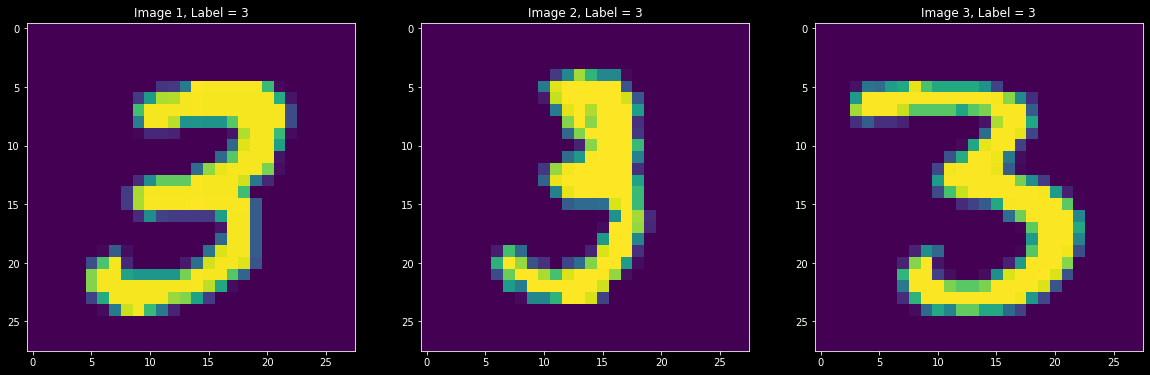

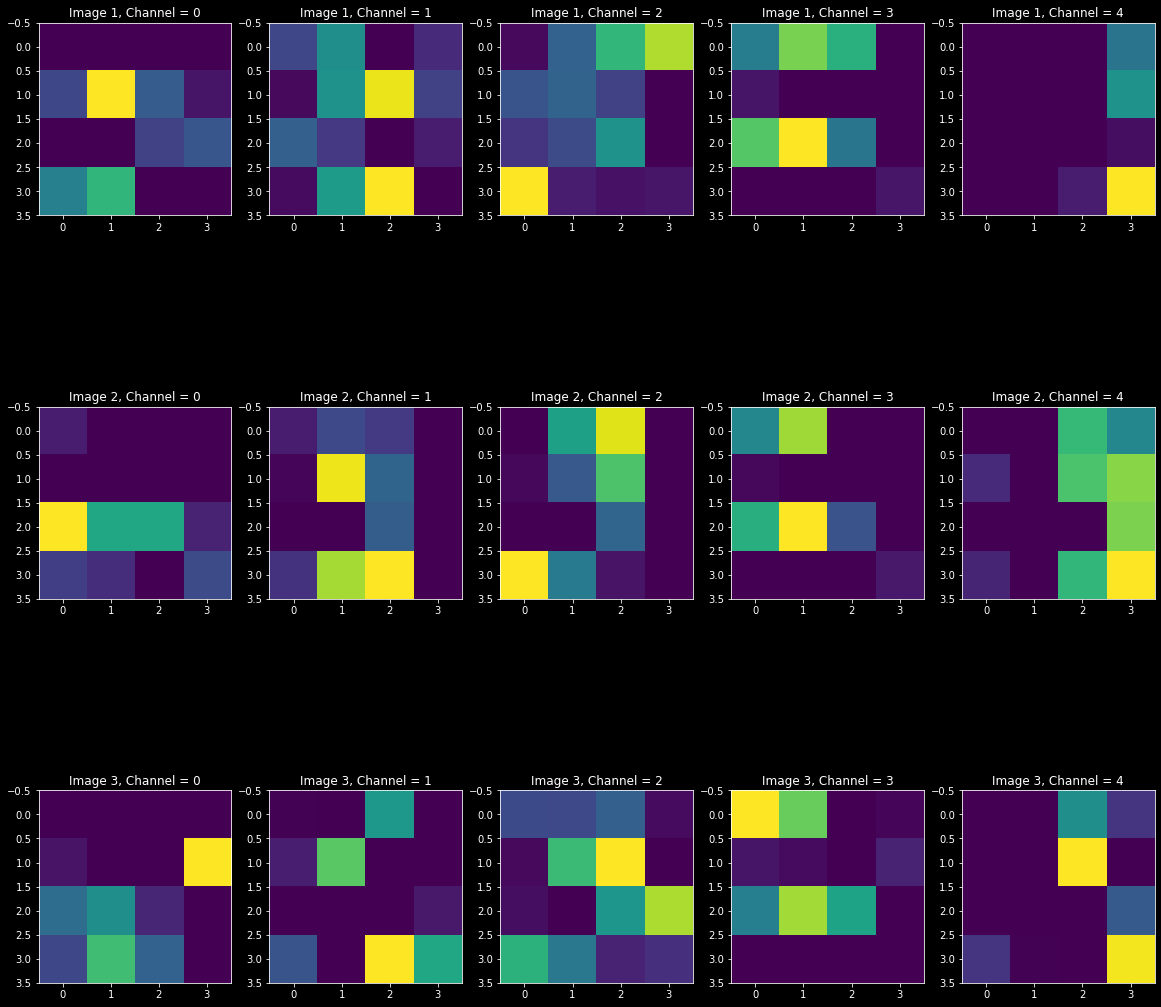

In [50]:
# Grab a batch from the data loader
# I reset my kernel, so this is the first batch.
imgs, labels = next(iter(data_loader))

# Grab some samples and labels from the batch. These are selected to be 3s.
ind1 = 7
ind2 = 10
ind3 = 12

cnn_inp1 = imgs[ind1:ind1+1]
label1 = labels[ind1]
cnn_inp2 = imgs[ind2:ind2+1]
label2 = labels[ind2]
cnn_inp3 = imgs[ind3:ind3+1]
label3 = labels[ind3]

# Show the original images
plt.figure(figsize = (20,20))
plt.subplot(1,3,1)
plt.imshow(cnn_inp1.squeeze())
plt.title(f'Image 1, Label = {label1}')
plt.subplot(1,3,2)
plt.imshow(cnn_inp2.squeeze())
plt.title(f'Image 2, Label = {label2}')
plt.subplot(1,3,3)
plt.imshow(cnn_inp3.squeeze())
plt.title(f'Image 3, Label = {label3}')

# What we are doing is not totally evaluating, but it is not training.
model.eval()
with torch.no_grad():
    # This is just the CNN part, before this is flattened and passed to the MLP
    conv_out1 = model.convolution_part(cnn_inp1)
    conv_out2 = model.convolution_part(cnn_inp2)
    conv_out3 = model.convolution_part(cnn_inp3)
[_,n_channels,_,_] = conv_out1.shape

# Plot all of the channels for these images together.
plt.figure(figsize = (20,20))
for i in range(n_channels):
    plt.subplot(3,n_channels,1+i)
    plt.imshow(conv_out1[0,i,:,:])
    plt.title(f'Image 1, Channel = {i}')
    plt.subplot(3,n_channels,1+n_channels+i)
    plt.imshow(conv_out2[0,i,:,:])
    plt.title(f'Image 2, Channel = {i}')
    plt.subplot(3,n_channels,1+2*n_channels+i)
    plt.imshow(conv_out3[0,i,:,:])
    plt.title(f'Image 3, Channel = {i}')

# The above code could easily be put into a loop to plot over more inds, but that's unnecessary complexity for this.

Looking at the above channels, all for the same digit (3), there's really no noticeable trend. There are a few pixels that are high (yellow) in all of the images, but with 80 potential pixels to match, we are bound to have some of these matches just by chance. Also, there's no way to tell which channels came from which image.

In sum, there is no easy way to explain the intermediate channels of this CNN. In other words, CNNs quickly become difficult for humans to explain, which in general is a common problem and area of research within deep learning.

## Conclusion

In this notebook, we focused on two main aspects related to class:
1. The use, structure, and meaning of Convolutional Neural Networks in image classification
2. Possible intuitions or non-equation-based ways to think about iterative optimizers

We explored the first concept by creating our own CNN, calculating the sizes of all the dimensions of the Convolution and Pooling layers. We also looked at the intermediate channels that are output from the convolution / pooling layers, before they are flattened and fed into the Multilayer Perceptron layers. This demonstrated a fundamental understanding of the principles and architecture of CNNs. We also explored visualizing a loss landscape, by means of dimensionality reduction. We illustrated a method to visualize $L(\theta)$ by considering $\theta \in \text{Span} \{ \theta_a, \theta_b \}$. We discussed two ways to choose $\theta_a$ and $\theta_b$. The first method was to randomly choose these directions. The second was to choose them as the eigenvectors corresponding to the two largest eigenvalues of the Hessian. We illustrated the first method, but due to the implementation and run time difficulty of computing the Hessian, we did not demonstrate the second method. In sum, this notebook explored quite a few areas, mostly related to CNNs and loss surfaces.